# Crypto Currency Time Series Project

This notebook aims to deliver a tuned Prophet model capable of predicting price values of some of the most famous  
crypto currencies based on the past data

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Define API Params

First define the coin to predict, actual date and a past date of n years in the past.   
Lastly define other API params such as currency and number of decimals.

In [2]:
coin = 'ethereum'

In [3]:
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range'

In [4]:
years = 2

In [5]:
today = int(datetime.datetime.now().timestamp())

In [6]:
past_date = int((datetime.datetime.now() - datetime.timedelta(days=365 * years)).timestamp())

In [7]:
params = {'vs_currency': 'usd',
          'from': past_date,
          'to': today,
          'precision': 2}

In [8]:
response = requests.get(url, params=params).json()

In [9]:
df = pd.DataFrame(response["prices"], columns=["Timestamp", "Price"])
df.head()

,Timestamp,Price
0,1637193600000,4302.80
1,1637280000000,3993.85
2,1637366400000,4317.60
3,1637452800000,4436.19
4,1637539200000,4319.36


# Data Cleaning 

Change the date table to a more human readable format, from Timestamp to yyyy-mm-dd

In [10]:
df['Date']= df['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))

In [11]:
df['Timestamp'] = df['Date']

In [12]:
df.drop(columns=['Date'], inplace=True)

In [13]:
df.rename(columns={'Timestamp': 'Date'}, inplace=True)

In [14]:
df['Date']=pd.to_datetime(df['Date'])

In [15]:
df.head()

,Date,Price
0,2021-11-17,4302.80
1,2021-11-18,3993.85
2,2021-11-19,4317.60
3,2021-11-20,4436.19
4,2021-11-21,4319.36


In [16]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

<AxesSubplot:title={'center':'ethereum trend'}, xlabel='Date', ylabel='Price'>

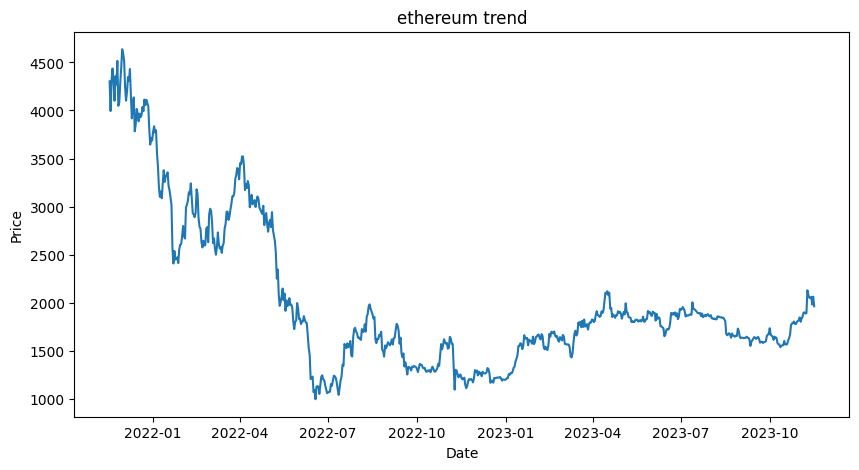

In [17]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend')
sns.lineplot(data=df, x='Date', y='Price')

# Prophet Model